Welcome to RFDiffusion loop mode. This notebook will generate binders for as many PDB files as you want in a loop.

To use, do the following:
- fill in **out_dir** with the directory you'd like your RFDiffusion sequences saved to
- upload **length.csv**, where the **"pdb"** column has the .pdb file name and the **"length"** column has the desired length (range) for its binder
- drop all your **.pdb** files into the Files area of the notebook

Example of **length.csv**

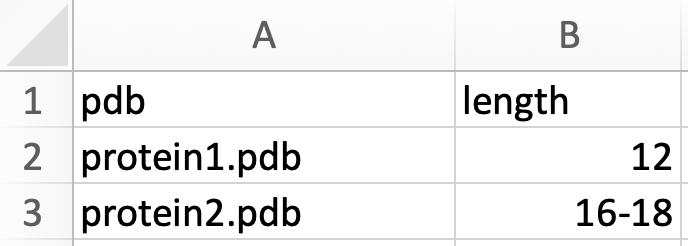

In [ ]:
#@title specify an output directory for your RFDiffusion sequences
out_dir = "# specify the path" #@param {type:"string"}

In [ ]:
#@title setup **RFdiffusion** (~2m)
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip -q install jedi omegaconf hydra-core icecream pyrsistent")
  os.system("pip install dgl==1.0.2+cu116 -f https://data.dgl.ai/wheels/cu116/repo.html")
  os.system("cd RFdiffusion/env/SE3Transformer; pip -q install --no-cache-dir -r requirements.txt; pip -q install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False,
                  num_designs=1, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      iterations = int(80 * (iterations / 200))
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    opts.append(f"ppi.hotspot_res=[{hotspot}]")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

In [ ]:
#@title Replace the designability_test.py file so AlphaFold doesn't run after ProteinMPNN
#@markdown - you must have a shortcut from **MyDrive** to **Programmable Biology Group** folder set up
from google.colab import files, drive
import shutil
drive.mount('/content/drive')

designability_test_path = '/content/drive/MyDrive/Programmable Biology Group/Sophie/Everything Else/Misc Resources/Model Colabs/rfdiffusion_run_files/designability_test.py'
# delete the old file
os.remove('colabdesign/rf/designability_test.py')
# upload the new file to the same spot
shutil.copyfile(designability_test_path, 'colabdesign/rf/designability_test.py')

In [ ]:
%%time
import os
import random
import string
import pandas as pd
from datetime import datetime

#@title run **RFdiffusion** to generate a backbone

##### diffusion parameters
# contigs = "A:15"
iterations = 25
hotspot = ""
num_designs = 1
visual = "image"

symmetry = "none"
order = 1
chains = ""
add_potential = True

#### proteinMPNN parameters
num_seqs = 1
initial_guess = True
num_recycles = 3
use_multimer = False
rm_aa = "C"
mpnn_sampling_temp = 0.1


# Get a list of .pdb files from the current directory
pdb_files = [f for f in os.listdir() if f.endswith('.pdb')]

contigs_dict = {}

# Load the length.csv file
length_df = pd.read_csv("length.csv").dropna()

# Create a dictionary mapping pdb names to their lengths
# length_dict = {f"t{i+1}": length for i, length in enumerate(length_df["length"])}
#.split('_')[0] if '_' in name else name

length_df["length"] = length_df["length"].astype(int)
length_df["pdb"] = length_df["pdb"].apply(lambda x: x.split('_')[0].replace('.pdb','') if '_' in x else x.replace('.pdb',''))
length_dict = {name: length for name, length in zip(length_df["pdb"], length_df["length"])}
print(length_dict)

# Loop through each pdb file and run diffusion
for pdb in pdb_files:
    # determine where to save
    name = pdb.split('_')[0].replace('.pdb','')
    path = name
    while os.path.exists(f"outputs/{path}_0.pdb"):
        path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

    # Get the length for the current pdb from the length_dict and set the contigs
    pdb_length = length_dict.get(name)  # Default to 15 if name not found
    contigs = f"A:{pdb_length}"
    print(contigs)

    flags = {
             "contigs": contigs,
             "pdb": pdb,
             "order": order,
             "iterations": iterations,
             "symmetry": symmetry,
             "hotspot": hotspot,
             "path": path,
             "chains": chains,
             "add_potential": add_potential,
             "num_designs": num_designs,
             "visual": visual
             }

    for k, v in flags.items():
        if isinstance(v, str):
            flags[k] = v.replace("'", "").replace('"', '')

    contigs, copies = run_diffusion(**flags)

    # save contigs in the dictionary
    contigs_dict[name] = contigs

    ## run proteinMPNN and save the results
    if os.path.isfile('outputs/{}_0.pdb'.format(name)):
      filepath = 'outputs/{}_0.pdb'.format(name)
      filename = filepath.split('/')[1] # Extract name
      path = os.path.splitext(filename)[0] # Extract name without .pdb extension

      # Extract the name from filename to look up in contigs_dict
      name = filename.split('_')[0]
      contigs = contigs_dict.get(name)  # if not found in the dictionary, there'll be an error

      print(name)
      print(contigs)

      contigs_str = ":".join(contigs)
      print(contigs_str)

      opts = [f"--pdb={filepath}",
              f"--loc=outputs/{path}",
              f"--contig={contigs_str}",
              f"--copies={copies}",
              f"--num_seqs={num_seqs}",
              f"--num_recycles={num_recycles}",
              f"--rm_aa={rm_aa}",
              f"--mpnn_sampling_temp={mpnn_sampling_temp}",
              f"--num_designs={num_designs}"]
      if initial_guess: opts.append("--initial_guess")
      if use_multimer: opts.append("--use_multimer")

      opts = ' '.join(opts)
      print('printing opts!', opts)

      # Execute the script with current options
      !python colabdesign/rf/designability_test.py {opts}

      # save the results to Drive
      # Construct the path to the mpnn_results.csv file in the current folder
      csv_path = os.path.join(f"outputs/{path}", "mpnn_results.csv")

      # Check if the CSV file exists
      if os.path.exists(csv_path):
        # Load the CSV using pandas
        df = pd.read_csv(csv_path)

        # Extract the binder information. It's stored as "binder"
        binder = df["binder"].iloc[0] # Assumes only one row
        target = df["target"].iloc[0]
        binder_len = len(binder)

        # Make a CSV with these results
        results_df = pd.DataFrame({
            "name": ['{}_0'.format(name)],
            "full_filename": [pdb],
            "target": [target],
            "binder": [binder],
            "binder_len": [binder_len],
        })

        dt = datetime.today().strftime('%Y-%m-%d')
        results_df.to_csv('{}/{}_0_results_{}.csv'.format(out_dir,name, dt))

      else:
        print('error for {}_0'.format(name))

    else:
        print('error for {}_0'.format(name))

# Print the dictionary to verify the saved contigs
print(contigs_dict)

In [ ]:
#@title Download Binders
import pandas as pd
# Define the folder where results are stored and the save path for the output CSV
results_folder = "outputs"
save_path = out_dir

# Create an empty list to store the results
binder_data = []

# Iterate through folders under 'outputs'
for folder in os.listdir(results_folder):
    if folder.endswith('_0'):
        # Construct the path to the mpnn_results.csv file in the current folder
        csv_path = os.path.join(results_folder, folder, "mpnn_results.csv")

        # Check if the CSV file exists
        if os.path.isfile(csv_path):
            # Load the CSV using pandas
            df = pd.read_csv(csv_path)

            # Extract the binder, target information
            binder = df["binder"].iloc[0]  # Assumes only one row
            target = df["target"].iloc[0]

            # Append the data to the list
            binder_data.append((folder.split('_')[0], target, binder, len(binder)))

# Convert the list to a DataFrame and save to CSV
binder_df = pd.DataFrame(binder_data, columns=["name", "target", "binder", "binder_len"])
binder_df.to_csv(f"{save_path}/binders_{dt}.csv", index=False)

In [ ]:
binder_df.to_csv('binders.csv')
files.download('binders.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>